Data Mining project  
AY 2022/23  
Task 3  
Group 12  
Leonardo Vona  
545042  

January 8. 2023

#**Classification**

In [ ]:
!pip install wittgenstein
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 124 kB 4.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import wittgenstein as lw

import scikitplot as skplt

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from keras import callbacks

import pydotplus
from IPython.display import Image  
from sklearn.tree import export_graphviz

from scipy.stats import randint as sp_randint



In [ ]:
users_df = pd.read_csv('./users_edited.csv', sep=',')

In [ ]:
models = []

## **Utilities**

The function 'discretize_data', discretizes the input variables from the input dataset.

In [ ]:
#input: the dataset and the list of variables' names to discretize
def discretize_data(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the numeric representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new column with the numeric representation of the variable
        dataset[variable] = dataset[variable].map(mapping).astype(int)
    return dataset

The function 'report_scores' shows the main classification metrics with respect to the given predictions.

In [ ]:
def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=['Genuine', 'Bot']))

The function 'one_hot_encode' encoded the input categorical features from the input dataset into a one-hot numeric array.

In [ ]:
def one_hot_encode(dataset, features):
  ohe = OneHotEncoder()

  # encoded values of input features
  encoded_features = pd.DataFrame(ohe.fit_transform(dataset[features]).toarray())
  encoded_features.columns = ohe.get_feature_names_out(features)

  # merge with dataset on key values
  dataset = dataset.join(encoded_features)

  dataset.drop(features, axis=1, inplace=True)

  return dataset

The function 'compare_plots' compares the actual labels with respect to the predicted labels of a given classifier, over the features 'entropy_hour' and 'entropy_publication_rate'

In [ ]:
def compare_plots(dataset, label, pred):
  fig, ax = plt.subplots(1,2, figsize=(17,6))

  #true labels
  ax[0].scatter(dataset['entropy_hour'].values, dataset['entropy_publication_rate'].values, c=label.values, s=25, cmap='tab20b')
  ax[0].set_title('True labels')
  ax[0].set_xlabel('entropy_hour')
  ax[0].set_ylabel('entropy_publication_rate')

  #predicted labels
  ax[1].scatter(dataset['entropy_hour'].values, dataset['entropy_publication_rate'].values, c=pred, s=25, cmap='tab20b')
  ax[1].set_title('Predicted labels')
  ax[1].set_xlabel('entropy_hour')
  ax[1].set_ylabel('entropy_publication_rate')

  plt.show()

## **Preprocessing**

In [ ]:
users_df

,id,name,lang,bot,created_at,statuses_count,num_tweets,num_retweets,avg_tweets_per_day,avg_retweets_per_tweet,...,cumulative_retweets,cumulative_replies,cumulative_favorites,cumulative_hashtags,cumulative_urls,cumulative_mentions,avg_tweet_length,entropy_hour,entropy_text_length,entropy_publication_rate
0,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76,118,0,0.944000,0.033898,...,4.0,0.0,5.0,13.0,0.0,35.0,63.0,2.551728,4.260846,3.117709
1,2358850842,Lourie Botton,en,0,2019-02-26 03:02:32,54,104,0,0.832000,0.028846,...,3.0,0.0,6.0,3.0,0.0,38.0,70.0,2.289363,4.129301,2.927789
2,137959629,Dadan Syarifudin,en,1,2015-04-30 07:09:56,3,3,0,3.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,17.0,1.098612,1.098612,0.061140
3,466124818,Carletto Focia,it,1,2017-01-18 02:49:18,50,1243,6,1.373481,0.074014,...,92.0,0.0,240.0,78.0,32.0,1.0,89.0,2.899550,4.676458,6.346154
4,2571493866,MBK Ebook,en,0,2019-06-18 19:30:21,7085,3175,0,26.239669,0.017638,...,56.0,0.0,205.0,431.0,3.0,1718.0,75.0,3.169970,4.758071,7.656939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11503,2911861962,Madrid Lae Maika .,en,0,2019-11-29 13:16:02,1126,644,175,5.551724,0.026398,...,17.0,0.0,59.0,108.0,8.0,341.0,42.0,2.551332,4.460530,4.949455
11504,1378532629,Clau Sato,en,0,2018-04-27 03:01:58,3024,1633,109,2.224796,0.015309,...,25.0,0.0,419.0,182.0,159.0,814.0,57.0,2.804941,4.723266,6.167495
11505,126984069,ALMA LETICIA NUÑO,es,0,2015-03-29 17:01:24,6,6,0,0.006250,0.000000,...,0.0,0.0,0.0,2.0,4.0,2.0,68.0,1.329661,1.791759,0.880575
11506,2383025796,Minnie Guadagno,en,1,2019-03-13 02:44:13,42,91,0,0.728000,0.076923,...,7.0,0.0,8.0,1.0,0.0,37.0,65.0,2.353112,4.103275,2.903829


The 'id' and 'name' features are not useful for the classification task, so I drop them.

In [ ]:
users_df = users_df.drop(['id', 'name'], axis=1)

The binary target label 'bot' is first converted into an integer (0 / 1) and then removed from the data set.

In [ ]:
users_df = discretize_data(users_df, ['bot'])
label = users_df.pop('bot')

### **lang**

The 'lang' feature contains many entries with low frequency (less than 30), which can be grouped together into the single entry 'Other' to reduce possible overfitting.

In [ ]:
users_df['lang'].value_counts(sort=False)

en       9972
it        906
fr         36
ru         42
es        319
tr         14
en-gb      54
pt         65
nl          6
id         12
zh-tw      20
ja         33
de          8
ko          9
en-AU       1
da          2
ar          3
zh-cn       1
pl          1
el          1
fil         1
sv          1
xx-lc       1
Name: lang, dtype: int64

In [ ]:
users_df['lang'] = users_df['lang'].mask(users_df['lang'].map(users_df['lang'].value_counts()) < 30, 'Other')

In [ ]:
users_df['lang'].value_counts()

en       9972
it        906
es        319
Other      81
pt         65
en-gb      54
ru         42
fr         36
ja         33
Name: lang, dtype: int64

### **created_at**

The datetime 'created_at' feature can't be used as it is for the classification task. From that indicator it is possible to extract four new variables which could improve the classification performance:
- 'created_at_year': year of subscription
- 'created_at_weekday': day of the week of subscription
- 'created_at_day': day of the month of subscription
- 'created_at_hour': hour of the day of subscription

In [ ]:
users_df['created_at'] = pd.to_datetime(users_df['created_at'], infer_datetime_format=True, errors='coerce')

In [ ]:
users_df['created_at_year'] = users_df['created_at'].dt.year

In [ ]:
users_df['created_at_weekday'] = users_df['created_at'].dt.weekday

In [ ]:
users_df['created_at_day'] = users_df['created_at'].dt.day

In [ ]:
users_df['created_at_hour'] = users_df['created_at'].dt.hour

In [ ]:
users_df.drop('created_at', axis=1, inplace=True)

In [ ]:
users_df

,lang,statuses_count,num_tweets,num_retweets,avg_tweets_per_day,avg_retweets_per_tweet,avg_replies_per_tweet,avg_favorites_per_tweet,avg_hashtags_per_tweet,avg_mentions_per_tweet,...,cumulative_urls,cumulative_mentions,avg_tweet_length,entropy_hour,entropy_text_length,entropy_publication_rate,created_at_year,created_at_weekday,created_at_day,created_at_hour
0,en,76,118,0,0.944000,0.033898,0.0,0.042373,0.110169,0.296610,...,0.0,35.0,63.0,2.551728,4.260846,3.117709,2019,4,22,18
1,en,54,104,0,0.832000,0.028846,0.0,0.057692,0.028846,0.365385,...,0.0,38.0,70.0,2.289363,4.129301,2.927789,2019,1,26,3
2,en,3,3,0,3.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,17.0,1.098612,1.098612,0.061140,2015,3,30,7
3,it,50,1243,6,1.373481,0.074014,0.0,0.193081,0.062751,0.000805,...,32.0,1.0,89.0,2.899550,4.676458,6.346154,2017,2,18,2
4,en,7085,3175,0,26.239669,0.017638,0.0,0.064567,0.135748,0.541102,...,3.0,1718.0,75.0,3.169970,4.758071,7.656939,2019,1,18,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11503,en,1126,644,175,5.551724,0.026398,0.0,0.091615,0.167702,0.529503,...,8.0,341.0,42.0,2.551332,4.460530,4.949455,2019,4,29,13
11504,en,3024,1633,109,2.224796,0.015309,0.0,0.256583,0.111451,0.498469,...,159.0,814.0,57.0,2.804941,4.723266,6.167495,2018,4,27,3
11505,es,6,6,0,0.006250,0.000000,0.0,0.000000,0.333333,0.333333,...,4.0,2.0,68.0,1.329661,1.791759,0.880575,2015,6,29,17
11506,en,42,91,0,0.728000,0.076923,0.0,0.087912,0.010989,0.406593,...,0.0,37.0,65.0,2.353112,4.103275,2.903829,2019,2,13,2


## **Baseline performance**

It is useful to have a baseline performance to compare with the classification models that will be built, so that it is possible to understand their meaningfulness.

The baseline performance are obtained using a DummyClassifier, which in the following settings always returns the most frequent class label as result.

In [ ]:
train_set_bl, test_set_bl, train_label_bl, test_label_bl = train_test_split(users_df, label, stratify = label, test_size=0.30)

clf = DummyClassifier(strategy= 'most_frequent').fit(train_set_bl, train_label_bl)
test_pred_bl = clf.predict(test_set_bl)

The performance of the DummyClassifier are reported below, showing that it always outputs the class label 1 ('Bot'), which is the most frequent one. The accuracy of the baseline model corresponds to the percentage of bots in the test set, which is 0.53.

In [ ]:
print ('Baseline performance on test set: \n')
report_scores(test_label_bl, test_pred_bl)

Baseline performance on test set: 

              precision    recall  f1-score   support

     Genuine       0.00      0.00      0.00      1618
         Bot       0.53      1.00      0.69      1835

    accuracy                           0.53      3453
   macro avg       0.27      0.50      0.35      3453
weighted avg       0.28      0.53      0.37      3453



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
models.append({
    'name': 'Baseline', 
    'accuracy': accuracy_score(test_label_bl, test_pred_bl),
    'genuine_recall': recall_score(test_label_bl, test_pred_bl, pos_label = 0)
    })

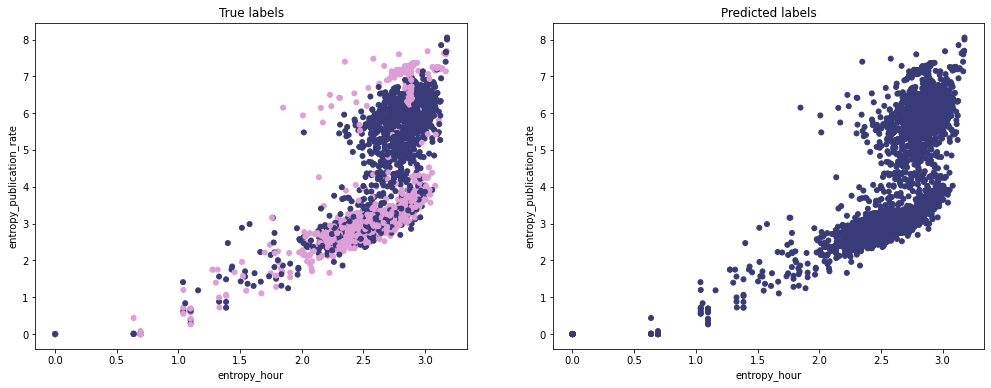

In [ ]:
compare_plots(test_set_bl, test_label_bl, test_pred_bl)

## **Decision Tree**

In [ ]:
users_dt_df = users_df.copy()

###**Preprocessing**

The 'lang' feature is converted as a one-hot numeric array in order to let the Decision Tree classifier to handle the indicator properly.

In [ ]:
users_dt_df = one_hot_encode(users_dt_df, ['lang'])

The data set is subdivided into train and test set in a 70/30 ratio, keeping the same proportions of the target class label 'bot' for both the derived sets.

In [ ]:
train_set_dt, test_set_dt, train_label_dt, test_label_dt = train_test_split(users_dt_df, label, stratify = label, test_size=0.30)

###**Finding the best parameters**

The class 0 is weighted 0.6 and the class 1 is weighted 0.4, so as to improve the recall for the class of genuine users.

In [ ]:
class_weight = {0: 0.6, 1: 0.4}

To find the best parameters of the DecisionTreeClassifier for the data set a randomized search with (5-fold) cross validation is set up.

I use a randomized search instead of an exhaustive grid search because evaluating all the possible combinations of the parameters would be infeasible.

The parameters over which the search is performed are:
- 'max_depth': maximum depth of the tree
- 'min_samples_split': minimum number of samples required to split an internal node
- 'min_samples_leaf': minimum number of samples required to be at a leaf node
- 'criterion': function to measure the "quality" of a split
- 'splitter': strategy used to choose the split at each node
- 'max_features': number of features to consider when looking for the best split

In [ ]:
dt_params_grid = {
    "max_depth": [2,4,6,8,10, None],
    "min_samples_split": sp_randint(2, 701),
    "min_samples_leaf": sp_randint(1, 701),
    "criterion": ["entropy", "gini"],
    "splitter": ["best", "random"],
    "max_features": [None, 2, 3, 4, 5, 6, 7]
            }

number_of_iterations = 10000

grid_search_dt = RandomizedSearchCV(
      DecisionTreeClassifier(class_weight = class_weight), 
      param_distributions=dt_params_grid, 
      n_iter=number_of_iterations,  
      n_jobs=-1,
      scoring='accuracy'
    )

grid_search_dt.fit(train_set_dt, train_label_dt)

print('Output parameters:',
      grid_search_dt.best_params_)

Output parameters: {'criterion': 'entropy', 'max_depth': 6, 'max_features': None, 'min_samples_leaf': 111, 'min_samples_split': 334, 'splitter': 'best'}


The results of the randomized search vary from time by time, but typically the cv accuracy obtained by the Decision Tree classifier for this data set is in the order of 83%.

In [ ]:
print('Accuracy score:', 
      grid_search_dt.cv_results_['mean_test_score'][grid_search_dt.best_index_], 
      '±',
      grid_search_dt.cv_results_['std_test_score'][grid_search_dt.best_index_])

Accuracy score: 0.834016139044072 ± 0.0050520148850095


###**Evaluation**

The classifier is built again with the best parameters obtained by the randomized search.

In [ ]:
dt_classifier = DecisionTreeClassifier(class_weight = class_weight, **grid_search_dt.best_params_)

dt_classifier.fit(train_set_dt, train_label_dt)

DecisionTreeClassifier(class_weight={0: 0.6, 1: 0.4}, criterion='entropy',
                       max_depth=6, min_samples_leaf=111,
                       min_samples_split=334)

It is possible to visualize the tree constructed by the classifier, which shows the features it uses to make the predictions and how the two classes of users are discriminated depending on their attributes.

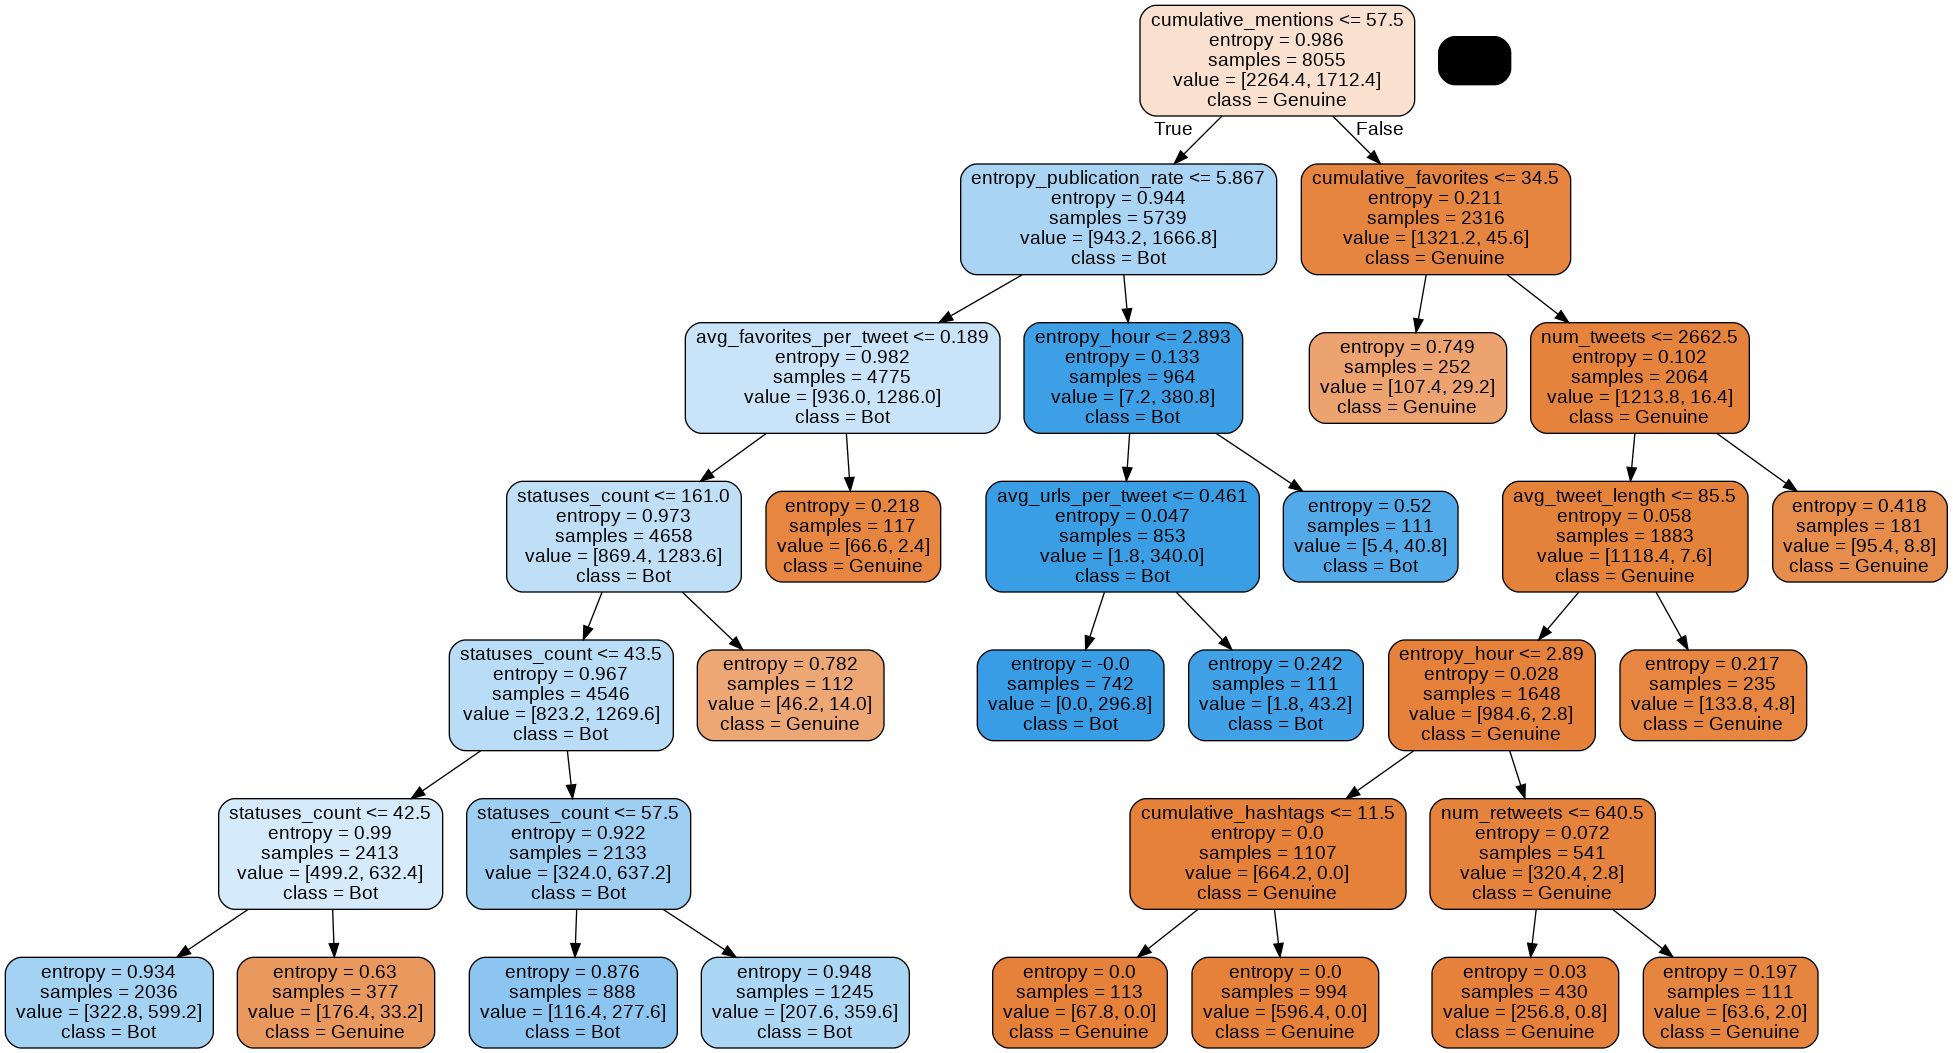

In [ ]:
dot_data = export_graphviz(dt_classifier, 
                                out_file=None, 
                                feature_names=list(train_set_dt.columns),  
                                class_names=['Genuine', 'Bot'],  
                                filled=True, 
                                rounded=True)  

graph = pydotplus.graph_from_dot_data(dot_data)  

Image(graph.create_png())

After training the classifier, it is possible to make the predictions on the test set and compare the performances with respect to the training set.

In [ ]:
train_pred_dt = dt_classifier.predict(train_set_dt)
test_pred_dt = dt_classifier.predict(test_set_dt)

In [ ]:
print('Accuracy train set ', accuracy_score(train_label_dt, train_pred_dt))
print('Accuracy test set ', accuracy_score(test_label_dt, test_pred_dt))

Accuracy train set  0.8351334574798261
Accuracy test set  0.8305821025195482


From the following tables it is possible to see that the model is very good in predicting the actual bots, but lacks in recognizing correctly genuine users, with a recall of 71% for the genuine users in the test set.

In [ ]:
print ('Decision Tree Classifier performance on training set: \n')
report_scores(train_label_dt, train_pred_dt)

Decision Tree Classifier performance on training set: 

              precision    recall  f1-score   support

     Genuine       0.92      0.71      0.80      3774
         Bot       0.79      0.94      0.86      4281

    accuracy                           0.84      8055
   macro avg       0.85      0.83      0.83      8055
weighted avg       0.85      0.84      0.83      8055



In [ ]:
print ('Decision Tree Classifier performance on test set: \n')
report_scores(test_label_dt, test_pred_dt)

Decision Tree Classifier performance on test set: 

              precision    recall  f1-score   support

     Genuine       0.91      0.70      0.80      1618
         Bot       0.78      0.94      0.86      1835

    accuracy                           0.83      3453
   macro avg       0.85      0.82      0.83      3453
weighted avg       0.84      0.83      0.83      3453



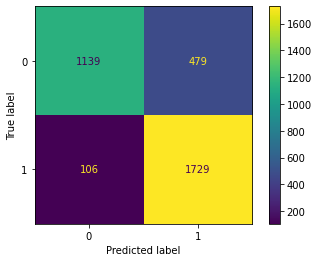

In [ ]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_label_dt, test_pred_dt)).plot()

plt.show() 

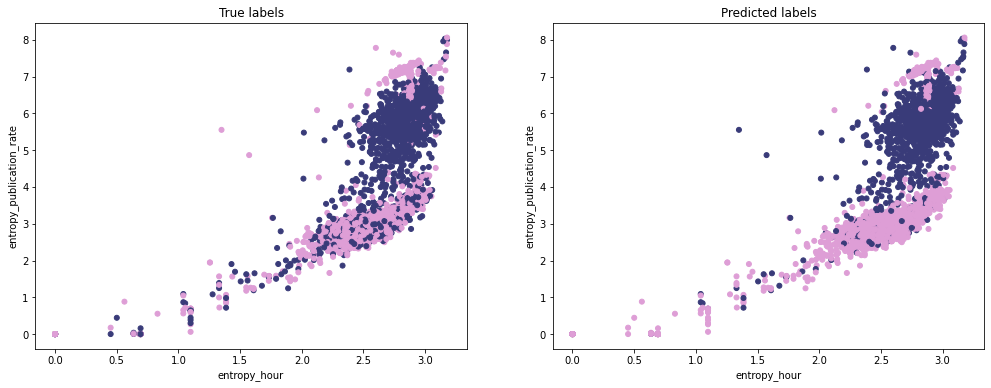

In [ ]:
compare_plots(test_set_dt, test_label_dt, test_pred_dt)

The problem of high false positives does not seem related to a possible poor generalization ability because the predictions on the training set are similar and neither to an unbalancement on the data because both classes are quite equally represented.

A possible explanation is that the features associated to the users do not permit to distinguish easily between the two classes because both genuine users and bots show a similar behavior in some cases.

From the plots above in particular it is possible to see that the classifier is able to distinguish well the two classes when there is a clear separation between them, and tends to misclassify the instances when they are mixed.

In [ ]:
models.append({
    'name': 'Decision tree', 
    'accuracy': accuracy_score(test_label_dt, test_pred_dt),
    'genuine_recall': recall_score(test_label_dt, test_pred_dt, pos_label = 0)
    })

## **K-NN**

In [ ]:
users_knn_df = users_df.copy()

###**Preprocessing**

K-NN is based on a notion of distance between instances in a multi-dimensional space, but the categorical feature 'lang' can't be converted to numerical with a meaningful distance between languages, so I decided to drop that attribute for this type of classifier.

In [ ]:
users_knn_df.drop(['lang'], axis=1, inplace=True)

Given that the number of features that characterize a user is quite high, to reduce possible overfitting due to the curse of dimensionality I decided to drop some features which, after some experiments, do not seem to be very informative for the actual classification model.

In [ ]:
users_knn_df.drop(['avg_tweets_per_day', 'avg_retweets_per_tweet', 'avg_replies_per_tweet',
                   'avg_favorites_per_tweet', 'cumulative_replies', 'cumulative_favorites', 'cumulative_hashtags',
                   'cumulative_urls', 'cumulative_mentions', 'created_at_year', 'created_at_weekday',
                   'created_at_day', 'created_at_hour'],
                  axis=1,
                  inplace=True)

In [ ]:
users_knn_df

,statuses_count,num_tweets,num_retweets,avg_hashtags_per_tweet,avg_mentions_per_tweet,avg_urls_per_tweet,cumulative_retweets,avg_tweet_length,entropy_hour,entropy_text_length,entropy_publication_rate
0,76,118,0,0.110169,0.296610,0.000000,4.0,63.0,2.551728,4.260846,3.117709
1,54,104,0,0.028846,0.365385,0.000000,3.0,70.0,2.289363,4.129301,2.927789
2,3,3,0,0.000000,0.000000,0.000000,0.0,17.0,1.098612,1.098612,0.061140
3,50,1243,6,0.062751,0.000805,0.025744,92.0,89.0,2.899550,4.676458,6.346154
4,7085,3175,0,0.135748,0.541102,0.000945,56.0,75.0,3.169970,4.758071,7.656939
...,...,...,...,...,...,...,...,...,...,...,...
11503,1126,644,175,0.167702,0.529503,0.012422,17.0,42.0,2.551332,4.460530,4.949455
11504,3024,1633,109,0.111451,0.498469,0.097367,25.0,57.0,2.804941,4.723266,6.167495
11505,6,6,0,0.333333,0.333333,0.666667,0.0,68.0,1.329661,1.791759,0.880575
11506,42,91,0,0.010989,0.406593,0.000000,7.0,65.0,2.353112,4.103275,2.903829


In order to avoid the distance measure to be dominated by attributes with high values, the features are scaled using a Min-Max Scaler.

In [ ]:
minmax_scaler = MinMaxScaler()

train_set_knn, test_set_knn, train_label_knn, test_label_knn = train_test_split(users_knn_df, label, stratify=label, test_size=0.30)

train_set_knn_norm = minmax_scaler.fit_transform(train_set_knn.values)
test_set_knn_norm = minmax_scaler.fit_transform(test_set_knn.values)


### **Finding the best parameters**

To find the best parameters of the KNeighborsClassifier for the data set a grid search with (5-fold) cross validation is set up.

The grid search is performed in the space of the combination of the values:
- number of neighbors: between 25 and 65
- metric to compare the distance between instances: euclidean or manhattan
- algorithm to compute the nearest neighbors: automatically determined
- weight function used in prediction: 'uniform' (all neighbors are weighted equally) or 'distance' (points weighted by the inverse of their distance)

In [ ]:
knn_params_grid = {
    'n_neighbors': range(25,66),
    'metric': ['euclidean', 'manhattan'],
    'algorithm': ['auto'],
    'weights': ['uniform', 'distance'],
            }

grid_search_knn = GridSearchCV(KNeighborsClassifier(), 
                               param_grid = knn_params_grid,
                               scoring='accuracy',
                               n_jobs=-1)

grid_search_knn.fit(train_set_knn_norm, train_label_knn)

grid_search_knn.best_params_

{'algorithm': 'auto',
 'metric': 'manhattan',
 'n_neighbors': 41,
 'weights': 'uniform'}

The cv accuracy obtained by the K-NN classifier for this data set is 80%.

In [ ]:
print('Accuracy score:', 
      grid_search_knn.cv_results_['mean_test_score'][grid_search_knn.best_index_], 
      '±',
      grid_search_knn.cv_results_['std_test_score'][grid_search_knn.best_index_])

Accuracy score: 0.7977653631284916 ± 0.005734976765959571


###**Evaluation**

The classifier is built again with the best parameters obtained by the grid search.

In [ ]:
knn_classifier = KNeighborsClassifier(**grid_search_knn.best_params_)

knn_classifier.fit(train_set_knn_norm, train_label_knn)

KNeighborsClassifier(metric='manhattan', n_neighbors=41)

After training the classifier, it is possible to make the predictions on the test set and compare the performances with respect to the training set.

In [ ]:
train_pred_knn = knn_classifier.predict(train_set_knn_norm)
test_pred_knn = knn_classifier.predict(test_set_knn_norm)

In [ ]:
print('Accuracy train set ', accuracy_score(train_label_knn, train_pred_knn))
print('Accuracy test set ', accuracy_score(test_label_knn, test_pred_knn))

Accuracy train set  0.7992551210428306
Accuracy test set  0.8126267014190559


In [ ]:
print ('KNN Classifier performance on training set: \n')
report_scores(train_label_knn,train_pred_knn)

KNN Classifier performance on training set: 

              precision    recall  f1-score   support

     Genuine       0.94      0.61      0.74      3774
         Bot       0.74      0.97      0.84      4281

    accuracy                           0.80      8055
   macro avg       0.84      0.79      0.79      8055
weighted avg       0.83      0.80      0.79      8055



In [ ]:
print ('KNN Classifier performance on test set: \n')
report_scores(test_label_knn,test_pred_knn)

KNN Classifier performance on test set: 

              precision    recall  f1-score   support

     Genuine       0.94      0.64      0.76      1618
         Bot       0.75      0.96      0.85      1835

    accuracy                           0.81      3453
   macro avg       0.85      0.80      0.80      3453
weighted avg       0.84      0.81      0.81      3453



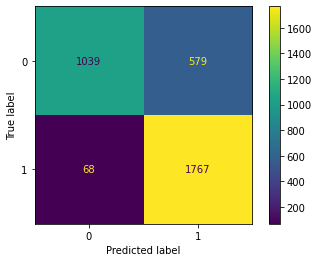

In [ ]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_label_knn, test_pred_knn)).plot()

plt.show() 

The K-NN classifier results to be less accurate in the predictions with respect to the Decision Tree, in particular with a significant increase of false positives.

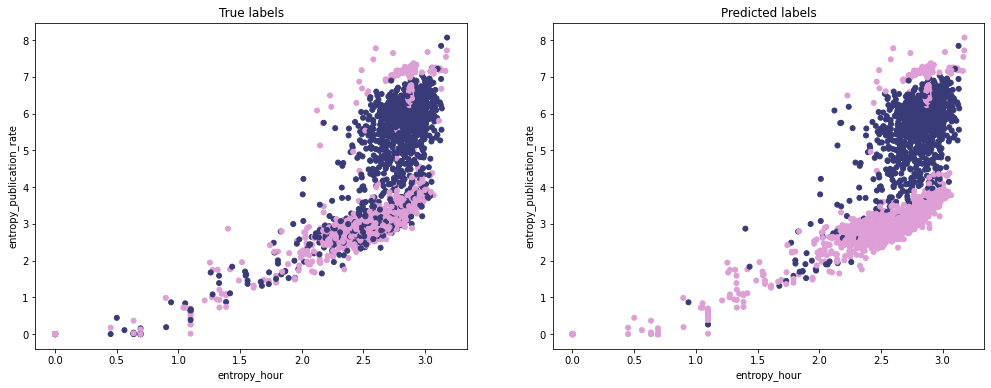

In [ ]:
compare_plots(test_set_knn, test_label_knn, test_pred_knn)

In [ ]:
models.append({
    'name': 'K-NN', 
    'classifier': knn_classifier,
    'accuracy': accuracy_score(test_label_knn, test_pred_knn),
    'genuine_recall': recall_score(test_label_knn, test_pred_knn, pos_label = 0)
    })

## **Rule based classifier**

In [ ]:
users_rb_df = users_df.copy()

In [ ]:
users_rb_df.columns

Index(['lang', 'statuses_count', 'num_tweets', 'num_retweets',
       'avg_tweets_per_day', 'avg_retweets_per_tweet', 'avg_replies_per_tweet',
       'avg_favorites_per_tweet', 'avg_hashtags_per_tweet',
       'avg_mentions_per_tweet', 'avg_urls_per_tweet', 'cumulative_retweets',
       'cumulative_replies', 'cumulative_favorites', 'cumulative_hashtags',
       'cumulative_urls', 'cumulative_mentions', 'avg_tweet_length',
       'entropy_hour', 'entropy_text_length', 'entropy_publication_rate',
       'created_at_year', 'created_at_weekday', 'created_at_day',
       'created_at_hour'],
      dtype='object')

### **Preprocessing**

Binning can be applied as a preprocessing step for the Rule based classifier to smooth the input data and then reduce the chances of overfitting caused by excessively specific rules, which reduce the generalization capabilities of the model.

The implementation of RIPPER used to build the model automatically applies binning to the features.

In [ ]:
train_set_rb, test_set_rb, train_label_rb, test_label_rb = train_test_split(users_rb_df, label, stratify = label, test_size=0.30)

The Rule based classifier used in this context is RIPPER, which is a direct method (extract rules directly from data).

For 2-class problem, as in this case, it chooses one of the classes as positive class, and the other as negative class
  - Learn rules for positive class
  - Negative class will be default class

### **Finding the best parameters**

A grid search is performed to find the best combination of parameters, which are:
- 'prune_size', which is the grow / prune proportion
- 'k', which is the number of optimization runs

In [ ]:
rb_params_grid = {
    "prune_size": [0.5, 0.6, 0.7],
    "k": [1, 3, 5]
        }

grid_search_rb = GridSearchCV(lw.RIPPER(),
                              param_grid=rb_params_grid,
                              n_jobs=-1,
                              scoring='accuracy')

grid_search_rb.fit(train_set_rb, train_label_rb)

grid_search_rb.best_params_

{'k': 5, 'prune_size': 0.5}

The cv accuracy obtained by the RIPPER classifier for this data set is 81-82%.

In [ ]:
print('Accuracy score:', 
      grid_search_rb.cv_results_['mean_test_score'][grid_search_rb.best_index_], 
      '±',
      grid_search_rb.cv_results_['std_test_score'][grid_search_rb.best_index_])

Accuracy score: 0.8168839230291745 ± 0.006719984408553367


### **Evaluation**

The classifier is built again with the best parameters obtained by the grid search.

In [ ]:
rb_classifier = lw.RIPPER(**grid_search_rb.best_params_)

rb_classifier.fit(pd.concat([train_set_rb, train_label_rb], axis=1), class_feat='bot')

The following output shows the model built by RIPPER, which is a set of rules.

In [ ]:
rb_classifier.out_model()

[[num_retweets=<2.0 ^ statuses_count=5332.4-13563.6 ^ num_tweets=>2141.6] V
[num_retweets=<2.0 ^ statuses_count=55.0-66.0 ^ avg_tweet_length=64.0-66.0] V
[num_retweets=<2.0 ^ cumulative_mentions=<1.0 ^ statuses_count=<20.0] V
[num_retweets=<2.0 ^ statuses_count=43.0-55.0 ^ entropy_hour=2.29-2.43 ^ cumulative_hashtags=5.0-7.0] V
[num_retweets=<2.0 ^ statuses_count=20.0-35.0 ^ cumulative_hashtags=5.0-7.0] V
[num_retweets=<2.0 ^ statuses_count=20.0-35.0 ^ created_at_hour=9.0-12.0 ^ avg_urls_per_tweet=<0.001] V
[num_retweets=<2.0 ^ statuses_count=55.0-66.0 ^ entropy_text_length=4.19-4.29] V
[num_retweets=<2.0 ^ created_at_year=2017 ^ lang=it] V
[num_retweets=<2.0 ^ statuses_count=43.0-55.0 ^ created_at_hour=12.0-15.0 ^ avg_tweet_length=61.0-64.0] V
[num_retweets=<2.0 ^ statuses_count=43.0-55.0 ^ entropy_publication_rate=2.82-2.93 ^ created_at_weekday=1] V
[num_retweets=<2.0 ^ created_at_year=2019 ^ statuses_count=43.0-55.0 ^ avg_hashtags_per_tweet=0.063-0.075] V
[num_retweets=<2.0 ^ status

After training the classifier, it is possible to make the predictions on the test set and compare the performances with respect to the training set.

In [ ]:
train_pred_rb = rb_classifier.predict(train_set_rb)
test_pred_rb = rb_classifier.predict(test_set_rb)

In [ ]:
print ('RIPPER (Rule Based Classifier) performance on training set: \n')
report_scores(train_label_rb, train_pred_rb)

RIPPER (Rule Based Classifier) performance on training set: 

              precision    recall  f1-score   support

     Genuine       0.92      0.71      0.80      3774
         Bot       0.79      0.95      0.86      4281

    accuracy                           0.84      8055
   macro avg       0.86      0.83      0.83      8055
weighted avg       0.85      0.84      0.83      8055



In [ ]:
print ('RIPPER (Rule Based Classifier) performance on test set: \n')
report_scores(test_label_rb, test_pred_rb)

RIPPER (Rule Based Classifier) performance on test set: 

              precision    recall  f1-score   support

     Genuine       0.90      0.67      0.77      1618
         Bot       0.76      0.93      0.84      1835

    accuracy                           0.81      3453
   macro avg       0.83      0.80      0.80      3453
weighted avg       0.82      0.81      0.80      3453



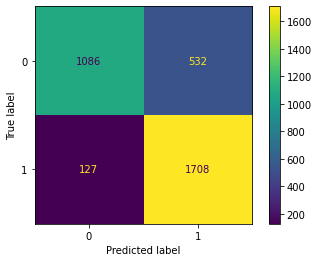

In [ ]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_label_rb, test_pred_rb)).plot()

plt.show() 

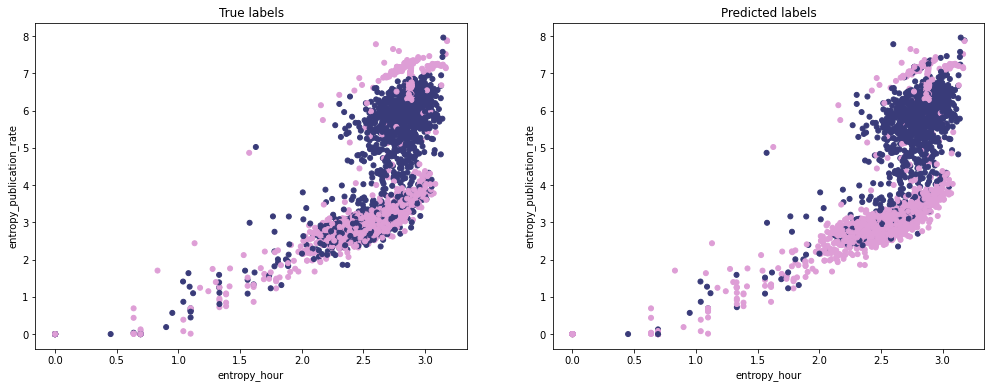

In [ ]:
compare_plots(test_set_rb, test_label_rb, test_pred_rb)

The Rule based classifier results to be slightly less accurate in the predictions with respect to the Decision Tree, especially with a smaller generalization capability, probably due to an excessive complexity of the rule set.

In [ ]:
models.append({
    'name': 'RIPPER', 
    'classifier': rb_classifier,
    'accuracy': accuracy_score(test_label_rb, test_pred_rb),
    'genuine_recall': recall_score(test_label_rb, test_pred_rb, pos_label = 0)
    })

## **Naive Bayes Classifier**

In [ ]:
users_nb_df = users_df.copy()

The very highly skewed distribution of the features will probably preclude the Naive Bayes classifiers to produce good results, given that it is more suited for Gaussian distributed data.

### **Preprocessing**

In [ ]:
users_nb_df = one_hot_encode(users_nb_df, ['lang'])

In order to try to reduce the skewness, I apply a log transformation to the features.

In [ ]:
users_nb_df = np.log2(users_nb_df + 1)

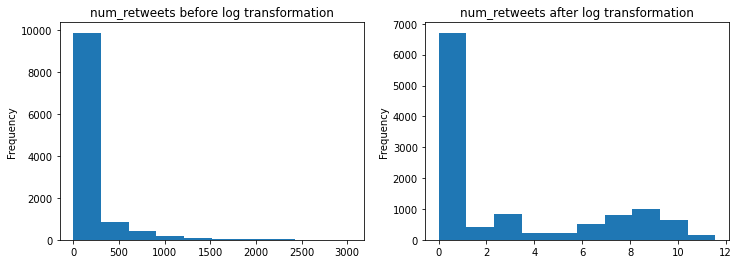

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

users_df['num_retweets'].plot.hist(ax=ax[0])
ax[0].set_title('num_retweets before log transformation')

users_nb_df['num_retweets'].plot.hist(ax=ax[1])
ax[1].set_title('num_retweets after log transformation')

plt.show()

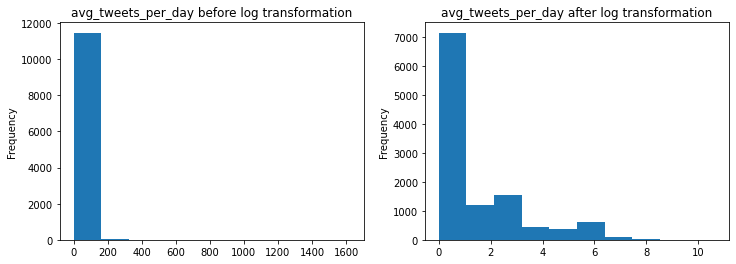

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

users_df['avg_tweets_per_day'].plot.hist(ax=ax[0])
ax[0].set_title('avg_tweets_per_day before log transformation')

users_nb_df['avg_tweets_per_day'].plot.hist(ax=ax[1])
ax[1].set_title('avg_tweets_per_day after log transformation')

plt.show()

  The distribution resulting from log transformation still shows an high skewness, but it is difficult to reduce it more due to the nature of the data.

In [ ]:
train_set_nb, test_set_nb, train_label_nb, test_label_nb = train_test_split(users_nb_df, label, stratify = label, test_size=0.30)

### **GaussianNB**

The Gaussian Naive Bayes algorithm for classification assumes the likelihood of the features to be Gaussian.

#### **Finding the best parameters**

A grid search is performed to find the best value for the parameter 'var_smoothing', which is a value added to the distribution's variance (derived from the training data set) to smooth the curve and increase the calculation stability.

In [ ]:
gnb_params_grid = {
    'var_smoothing': np.logspace(0,-9, num=100)
        }

grid_search_gnb = GridSearchCV(GaussianNB(), 
                               param_grid=gnb_params_grid,
                               n_jobs=-1,
                               scoring='accuracy')

grid_search_gnb.fit(train_set_nb, train_label_nb)

grid_search_gnb.best_params_

{'var_smoothing': 1.232846739442066e-06}

The cv accuracy obtained by the Gaussian Naive Bayes classifier for this data set is 77%.

In [ ]:
print('Accuracy score:', 
      grid_search_gnb.cv_results_['mean_test_score'][grid_search_gnb.best_index_], 
      '±',
      grid_search_gnb.cv_results_['std_test_score'][grid_search_gnb.best_index_])

Accuracy score: 0.764245810055866 ± 0.011051130023224267


#### **Evaluation**

The classifier is built again with the best parameter configuration obtained by the grid search.

In [ ]:
gnb_classifier = GaussianNB(**grid_search_gnb.best_params_)

gnb_classifier.fit(train_set_nb, train_label_nb)

GaussianNB(var_smoothing=1.232846739442066e-06)

After training the classifier, it is possible to make the predictions on the test set and compare the performances with respect to the training set.

In [ ]:
train_pred_gnb = gnb_classifier.predict(train_set_nb)

test_pred_gnb = gnb_classifier.predict(test_set_nb)

In [ ]:
print ('Gaussian Naive Bayes Classifier performance on training set: \n')
report_scores(train_label_nb, train_pred_gnb)

Gaussian Naive Bayes Classifier performance on training set: 

              precision    recall  f1-score   support

     Genuine       0.83      0.62      0.71      3774
         Bot       0.73      0.89      0.80      4281

    accuracy                           0.76      8055
   macro avg       0.78      0.76      0.76      8055
weighted avg       0.78      0.76      0.76      8055



In [ ]:
print ('Gaussian Naive Bayes Classifier performance on test set: \n')
report_scores(test_label_nb,test_pred_gnb)

Gaussian Naive Bayes Classifier performance on test set: 

              precision    recall  f1-score   support

     Genuine       0.85      0.62      0.72      1618
         Bot       0.73      0.90      0.81      1835

    accuracy                           0.77      3453
   macro avg       0.79      0.76      0.76      3453
weighted avg       0.79      0.77      0.77      3453



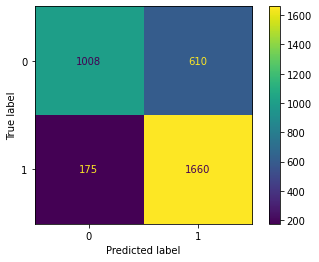

In [ ]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_label_nb, test_pred_gnb)).plot()

plt.show() 

As expected, the Gaussian Naive Bayes classifier is not particularly suited for this classification task, due to distribution of the features, which is very highly skewed.

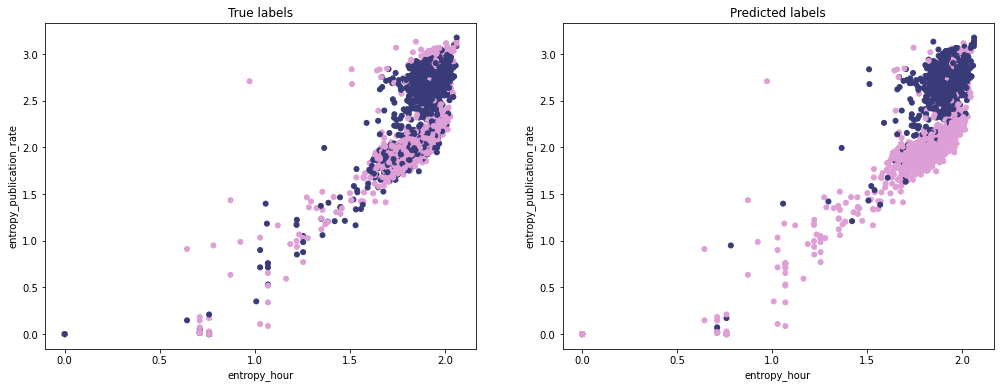

In [ ]:
compare_plots(test_set_nb, test_label_nb, test_pred_gnb)

In [ ]:
models.append({
    'name': 'Gaussian Naïve Bayes', 
    'classifier': gnb_classifier,
    'accuracy': accuracy_score(test_label_nb, test_pred_gnb),
    'genuine_recall': recall_score(test_label_nb, test_pred_gnb, pos_label = 0)
    })

### **MultinomialNB**

As its name suggests, the Multinomial Naive Bayes classifier is suited for multinomially distributed data.

#### **Finding the best parameters**

$\alpha$ is an additive (Laplace / Lidstone) smoothing parameter which regulates the behavior of the classifier when it encounters values of the features unseen during the training phase.

In [ ]:
mnb_params_grid = {
    "alpha": np.logspace(start = -10, stop = 1, num = 100)
          } 

grid_search_mnb = GridSearchCV(MultinomialNB(), 
                               param_grid=mnb_params_grid, 
                               n_jobs=-1,
                               scoring='accuracy')

grid_search_mnb.fit(train_set_nb, train_label_nb)

grid_search_mnb.best_params_

{'alpha': 1e-10}

The cv accuracy obtained by the Multinomial Naive Bayes classifier for this data set is 80%.

In [ ]:
print('Accuracy score:', 
      grid_search_mnb.cv_results_['mean_test_score'][grid_search_mnb.best_index_], 
      '±',
      grid_search_mnb.cv_results_['std_test_score'][grid_search_mnb.best_index_])

Accuracy score: 0.7993792675356921 ± 0.009334957763926755


#### **Evaluation**

The classifier is built again with the best parameter configuration obtained by the grid search.

In [ ]:
mnb_classifier = MultinomialNB(**grid_search_mnb.best_params_)

mnb_classifier.fit(train_set_nb, train_label_nb)

MultinomialNB(alpha=1e-10)

After training the classifier, it is possible to make the predictions on the test set and compare the performances with respect to the training set.

In [ ]:
train_pred_mnb = mnb_classifier.predict(train_set_nb)
test_pred_mnb = mnb_classifier.predict(test_set_nb)

In [ ]:
print ('Multinomial Naive Bayes Classifier performance on training set: \n')
report_scores(train_label_nb,train_pred_mnb)

Multinomial Naive Bayes Classifier performance on training set: 

              precision    recall  f1-score   support

     Genuine       0.93      0.62      0.74      3774
         Bot       0.74      0.96      0.84      4281

    accuracy                           0.80      8055
   macro avg       0.84      0.79      0.79      8055
weighted avg       0.83      0.80      0.79      8055



In [ ]:
print ('Multinomial Naive Bayes Classifier performance on test set: \n')
report_scores(test_label_nb,test_pred_mnb)

Multinomial Naive Bayes Classifier performance on test set: 

              precision    recall  f1-score   support

     Genuine       0.93      0.62      0.74      1618
         Bot       0.74      0.96      0.84      1835

    accuracy                           0.80      3453
   macro avg       0.83      0.79      0.79      3453
weighted avg       0.83      0.80      0.79      3453



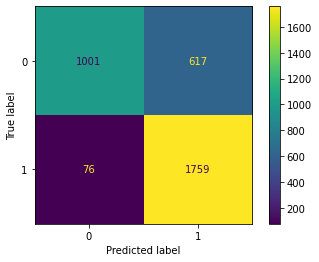

In [ ]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_label_nb, test_pred_mnb)).plot()

plt.show() 

The Multinomial Naive Bayes classifier shows good performances in predicting true genuine users and true bot users, but is very poor in the number of false positives detected.

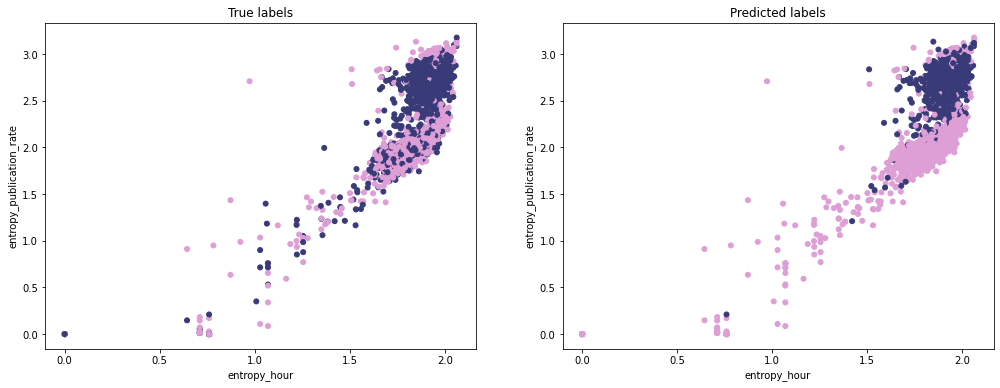

In [ ]:
compare_plots(test_set_nb, test_label_nb, test_pred_mnb)

In [ ]:
models.append({
    'name': 'Multinomial Naïve Bayes', 
    'classifier': mnb_classifier,
    'accuracy': accuracy_score(test_label_nb, test_pred_mnb),
    'genuine_recall': recall_score(test_label_nb, test_pred_mnb, pos_label = 0)
    })

## **Ensemble Methods**

Ensemble methods improve the accuracy by aggregating the predictions of multiple classifiers. They construct a set of base classifiers from the training data and then predict class label of test records by combining the predictions made by those multiple classifiers.

In [ ]:
users_en_df = users_df.copy()

### **Preprocessing**

In [ ]:
users_en_df = one_hot_encode(users_en_df, ['lang'])

In [ ]:
train_set_en, test_set_en, train_label_en, test_label_en = train_test_split(users_en_df, label, stratify = label, test_size=0.30)

### **AdaBoost**

AdaBoost is an ensemble method that manipulates data distribution. It performs multiple boosting rounds, each of which consists of training a base classifier based on a sampling (with replacement) of the data according to weights; the weights are updated at every round, depending on the performance of the classifier.

#### **Finding the best parameters**

The base estimator chosen for the AdaBoostClassifier is a DecisionTreeClassifier (which showed to perform well on the data set), with a maximum depth of 4.

To find the best parameters of the AdaBoostClassifier for the data set a grid search with (5-fold) cross validation is set up.

The grid search is performed on 'n_estimators', the maximum number of base estimators at which boosting is terminated, and 'learning_rate', which increases / decreases the contribution of each classifier at each boosting round.

In [ ]:
ab_params_grid = {
    "n_estimators": list(np.arange(150, 350, 50)),
    "learning_rate": np.arange(0.01, 0.11, 0.01)}

grid_search_ab = GridSearchCV(
    AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 4)),
    ab_params_grid,
    n_jobs=-1, 
    scoring='accuracy')

grid_search_ab.fit(train_set_en, train_label_en)

grid_search_ab.best_params_

{'learning_rate': 0.01, 'n_estimators': 300}

The cv accuracy obtained by the AdaBoost classifier for this data set is 84%.

In [ ]:
print('Accuracy score:', 
      grid_search_ab.cv_results_['mean_test_score'][grid_search_ab.best_index_], 
      '±',
      grid_search_ab.cv_results_['std_test_score'][grid_search_ab.best_index_])

Accuracy score: 0.840471756672874 ± 0.0070991823490978686


#### **Evaluation** 

The classifier is built again with the best parameters obtained by the grid search.

In [ ]:
ab_classifier = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 4), **grid_search_ab.best_params_)

ab_classifier.fit(train_set_en, train_label_en)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=4),
                   learning_rate=0.01, n_estimators=300)

After training the classifier, it is possible to make the predictions on the test set and compare the performances with respect to the training set.

In [ ]:
train_pred_ab = ab_classifier.predict(train_set_en)
test_pred_ab = ab_classifier.predict(test_set_en)

In [ ]:
print ('AdaBoost Classifier performance on training set: \n')
report_scores(train_label_en, train_pred_ab)

AdaBoost Classifier performance on training set: 

              precision    recall  f1-score   support

     Genuine       0.96      0.73      0.83      3774
         Bot       0.80      0.97      0.88      4281

    accuracy                           0.86      8055
   macro avg       0.88      0.85      0.85      8055
weighted avg       0.88      0.86      0.86      8055



In [ ]:
print ('AdaBoost Classifier performance on test set: \n')
report_scores(test_label_en, test_pred_ab)

AdaBoost Classifier performance on test set: 

              precision    recall  f1-score   support

     Genuine       0.94      0.70      0.80      1618
         Bot       0.79      0.96      0.86      1835

    accuracy                           0.84      3453
   macro avg       0.86      0.83      0.83      3453
weighted avg       0.86      0.84      0.84      3453



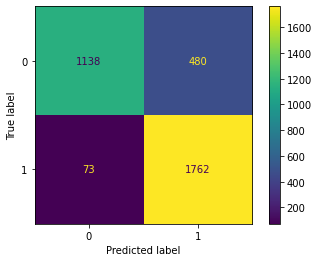

In [ ]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_label_en, test_pred_ab)).plot()

plt.show() 

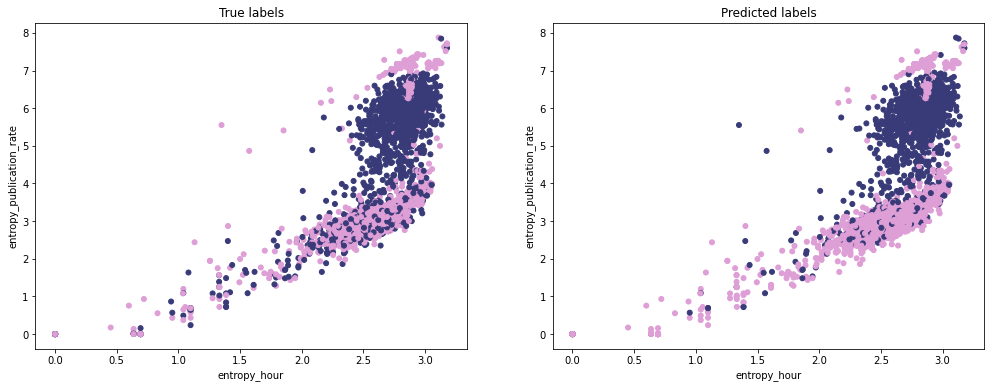

In [ ]:
compare_plots(test_set_en, test_label_en, test_pred_ab)

The AdaBoost classifier shows very good results in predicting actual genuine and bot users, but the number of false positives is still high.

In [ ]:
models.append({
    'name': 'AdaBoost', 
    'classifier': ab_classifier,
    'accuracy': accuracy_score(test_label_en, test_pred_ab),
    'genuine_recall': recall_score(test_label_en, test_pred_ab, pos_label = 0)
    })

### **RandomForest**

Is a class of ensemble methods specifically designed for decision trees, which combines the predictions made by multiple decision trees and outputs the class that is the mode of the class's output by individual trees.

Each decision tree is built on a bootstrap sample based on the values of an independent set of random vectors; unlike AdaBoost, the random vector are generated from a fixed probability distribution.

#### **Finding the best parameters**

The number of trees (n_estimators) used in the RandomForest is set to $\sqrt{m}$ where $m$ is the number of features.

The class 0 is weighted 0.6 and the class 1 is weighted 0.4, so as to improve the recall for the class of genuine users.

In [ ]:
n_estimators = int(np.rint(np.sqrt(len(train_set_en.iloc[0]))))
class_weight = {0: 0.6, 1: 0.4}

To find the best parameters of the RandomForestClassifier for the data set a randomized search with (5-fold) cross validation is set up.

The parameters over which the search is performed are:
- 'max_depth': maximum depth of the tree
- 'min_samples_split': minimum number of samples required to split an internal node
- 'min_samples_leaf': minimum number of samples required to be at a leaf node
- 'criterion': function to measure the "quality" of a split
- 'max_features': number of features to consider when looking for the best split
- 'bootstrap': whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree

In [ ]:
rf_params_grid = {
    "max_depth": [2,3,5,6,7,10,12,None],
    "max_features": sp_randint(1, len(train_set_en.iloc[0]) + 1),
    "min_samples_split": sp_randint(10, 51),
    "min_samples_leaf": sp_randint(10, 51),
    "bootstrap": [True, False],
    "criterion": ["entropy", "gini"],
        }

n_iter = 1000

grid_search_rf = RandomizedSearchCV(
    RandomForestClassifier(n_estimators=n_estimators, class_weight = class_weight), 
    param_distributions=rf_params_grid, 
    n_iter= n_iter, 
    n_jobs=-1, 
    scoring='accuracy')

grid_search_rf.fit(train_set_en, train_label_en)

grid_search_rf.best_params_

{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 7,
 'max_features': 22,
 'min_samples_leaf': 12,
 'min_samples_split': 15}

The cv accuracy obtained by the Random Forest classifier for this data set is 84%.

In [ ]:
print('Accuracy score:', 
      grid_search_rf.cv_results_['mean_test_score'][grid_search_rf.best_index_], 
      '±',
      grid_search_rf.cv_results_['std_test_score'][grid_search_rf.best_index_])

Accuracy score: 0.837492240844196 ± 0.006322945538545914


#### **Evaluation**

The classifier is built again with the best parameters obtained by the randomized search.

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=n_estimators, class_weight = class_weight, **grid_search_rf.best_params_)

rf_classifier.fit(train_set_en, train_label_en)

RandomForestClassifier(class_weight={0: 0.6, 1: 0.4}, criterion='entropy',
                       max_depth=7, max_features=22, min_samples_leaf=12,
                       min_samples_split=15, n_estimators=6)

After training the classifier, it is possible to make the predictions on the test set and compare the performances with respect to the training set.

In [ ]:
train_pred_rf = rf_classifier.predict(train_set_en)
test_pred_rf = rf_classifier.predict(test_set_en)

In [ ]:
print('Accuracy train set ', accuracy_score(train_label_en, train_pred_rf))
print('Accuracy test set ', accuracy_score(test_label_en, test_pred_rf))

Accuracy train set  0.8449410304158907
Accuracy test set  0.8355053576600058


In [ ]:
print ('Random Forest Classifier performance on training set: \n')
report_scores(train_label_en, train_pred_rf)

Random Forest Classifier performance on training set: 

              precision    recall  f1-score   support

     Genuine       0.93      0.72      0.81      3774
         Bot       0.79      0.95      0.87      4281

    accuracy                           0.84      8055
   macro avg       0.86      0.84      0.84      8055
weighted avg       0.86      0.84      0.84      8055



In [ ]:
print ('Random Forest Classifier performance on test set: \n')
report_scores(test_label_en, test_pred_rf)

Random Forest Classifier performance on test set: 

              precision    recall  f1-score   support

     Genuine       0.92      0.71      0.80      1618
         Bot       0.79      0.95      0.86      1835

    accuracy                           0.84      3453
   macro avg       0.86      0.83      0.83      3453
weighted avg       0.85      0.84      0.83      3453



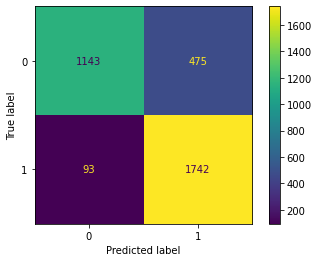

In [ ]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_label_en, test_pred_rf)).plot()

plt.show() 

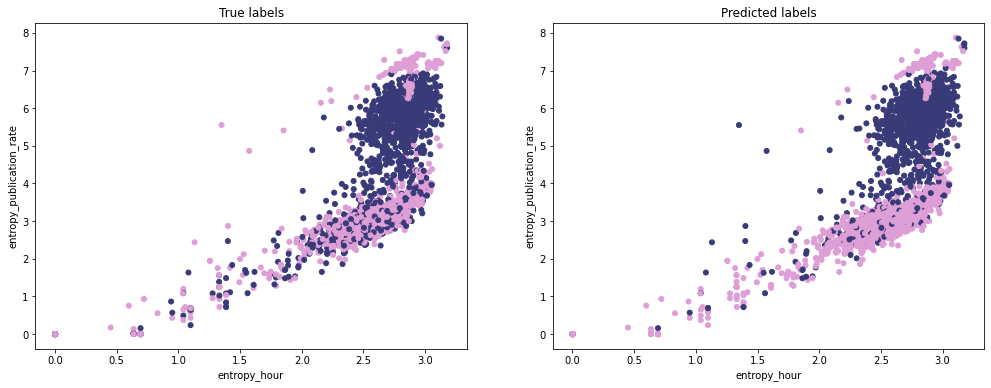

In [ ]:
compare_plots(test_set_en, test_label_en, test_pred_rf)

The performance of the Random Forest classifier are very comparable with the ones of the other enseble method AdaBoost. It is able to reach very high precision for the genuine class and recall for the bot class, but the results for the recall of genuine users are still in the order of 70%.

In [ ]:
models.append({
    'name': 'Random forest', 
    'classifier': rf_classifier,
    'accuracy': accuracy_score(test_label_en, test_pred_rf),
    'genuine_recall': recall_score(test_label_en, test_pred_rf, pos_label = 0)
    })

## **SVC**

A support vector machine (SVM) is a discriminative classification model that
learns linear or nonlinear decision boundaries in the attribute space to
separate the classes.

SVM maps training examples to points in space so as to maximise the width of the gap between the two categories. New examples are then mapped into that same space and predicted to belong to a category based on which side of the gap they fall.

In [ ]:
users_svm_df = users_df.copy()

### **Preprocessing**

The notion of distance is not meaningful for the attribute 'lang', so I decided to drop it.

In [ ]:
users_svm_df.drop(['lang'], axis=1, inplace=True)

The SVC is not scale invariant, then it is necessary to normalize the data before training the model.

In [ ]:
standard_scaler = StandardScaler()

train_set_svm, test_set_svm, train_label_svm, test_label_svm = train_test_split(users_svm_df, label, stratify=label, test_size=0.30)

train_set_svm_norm = standard_scaler.fit_transform(train_set_svm.values)
test_set_svm_norm = standard_scaler.fit_transform(test_set_svm.values)

### **Finding the best parameters**

The class 0 is weighted 0.6 and the class 1 is weighted 0.4, so as to improve the recall for the class of genuine users.

In [ ]:
class_weight = {0: 0.6, 1: 0.4}

A randomized search is set up to identify a good combination of parameters for the Support Vector classifier.

The parameters over which the search is performed are:
- 'kernel': kernel (type of hyperplane) to be used in the algorithm
- 'C': regularization parameter
- 'gamma': kernel coefficient
- 'class_weight': weights associated to each class 

In [ ]:
svm_params_grid = {
    "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
    "C": np.logspace(start = -1, stop = 1, num = 20),
    "gamma": ["scale", "auto"]
    }

n_iter = 50

grid_search_svm = RandomizedSearchCV(
    SVC(random_state=42, probability=True, class_weight=class_weight), 
    param_distributions=svm_params_grid, 
    n_iter= n_iter, 
    n_jobs=-1, 
    scoring='accuracy')

grid_search_svm.fit(train_set_svm_norm, train_label_svm)

grid_search_svm.best_params_

{'kernel': 'rbf', 'gamma': 'scale', 'C': 6.158482110660261}

The cv accuracy obtained by the SVC for this data set is 80 / 81%.

In [ ]:
print('Accuracy score:', 
      grid_search_svm.cv_results_['mean_test_score'][grid_search_svm.best_index_], 
      '±',
      grid_search_svm.cv_results_['std_test_score'][grid_search_svm.best_index_])

Accuracy score: 0.8121663563004345 ± 0.004975161988706114


### **Evaluation**

The classifier is built again with the best parameters obtained by the randomized search.

In [ ]:
svm_classifier = SVC(random_state=42, probability=True, class_weight=class_weight, **grid_search_svm.best_params_)

svm_classifier.fit(train_set_svm_norm, train_label_svm)

SVC(C=6.158482110660261, class_weight={0: 0.6, 1: 0.4}, probability=True,
    random_state=42)

It is possible to obtain the prediction probabilities computed by SVC for each sample in the test set.

In [ ]:
test_pred_proba_svm = svm_classifier.predict_proba(test_set_svm_norm)

test_pred_proba_svm

array([[0.23280829, 0.76719171],
       [0.43271814, 0.56728186],
       [0.23344572, 0.76655428],
       ...,
       [0.23517757, 0.76482243],
       [0.28068465, 0.71931535],
       [0.2780364 , 0.7219636 ]])

After training the classifier, it is possible to make the predictions on the test set and compare the performances with respect to the training set.

In [ ]:
train_pred_svm = svm_classifier.predict(train_set_svm_norm)
test_pred_svm = svm_classifier.predict(test_set_svm_norm)

In [ ]:
print('Accuracy train set ', accuracy_score(train_label_svm, train_pred_svm))
print('Accuracy test set ', accuracy_score(test_label_svm, test_pred_svm))

Accuracy train set  0.8335195530726257
Accuracy test set  0.7990153489719085


In [ ]:
print('SVM performance on training set: \n')
report_scores(train_label_svm, train_pred_svm)

SVM performance on training set: 

              precision    recall  f1-score   support

     Genuine       0.97      0.67      0.79      3774
         Bot       0.77      0.98      0.86      4281

    accuracy                           0.83      8055
   macro avg       0.87      0.82      0.83      8055
weighted avg       0.86      0.83      0.83      8055



In [ ]:
print('SVM performance on test set: \n')
report_scores(test_label_svm, test_pred_svm)

SVM performance on test set: 

              precision    recall  f1-score   support

     Genuine       0.93      0.61      0.74      1618
         Bot       0.74      0.96      0.84      1835

    accuracy                           0.80      3453
   macro avg       0.84      0.79      0.79      3453
weighted avg       0.83      0.80      0.79      3453



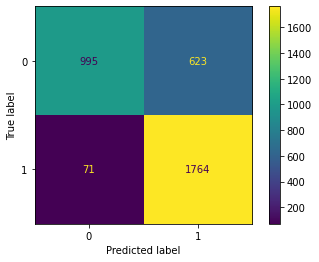

In [ ]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_label_svm, test_pred_svm)).plot()

plt.show() 

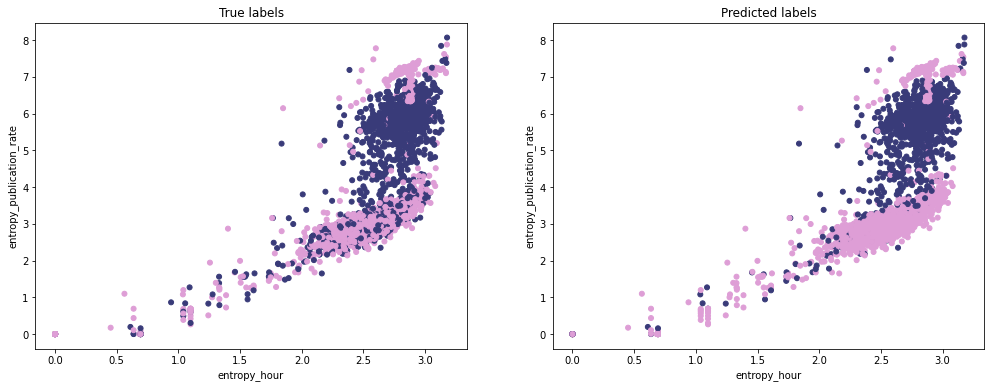

In [ ]:
compare_plots(test_set_svm, test_label_svm, test_pred_svm)

The SVC does not seem particularly suited for this data set; the number of true positives and negatives is quite high, but the model is penalized in the recall obtained for the class of genuine users, which is fairly lower if compared with other models such as Decision Tree or Random Forest, for instance.

These results probably come from the fact that the two classes does not separate well in the hyperplane created by the SVC, and then the model is not able to identify support vectors that can make a clear subdivision between different classes instances.

By using the prediction probabilities computed by SVC for the elements in the test set, it is possible to plot the ROC curves for both classes of users, and the relative micro- and macro-average ROC curves.

By interpreting the plot, we can understand that the classifier, for the class 0 (genuine users) is able to get a true positive rate of ~ 60% quite easily, keeping the false positive rate very low, but when it tries to reach higher TP rates, the FP rate increases very quickly. This tendency is also evident in the poor recall obtained by the model for the class of genuine users.

For what concerns the class 1 (bot users), even if the area under the curve is the same for both classes, the model gets better results with respect to class 0, obtaining TP rates higher than 85 - 90% with a FP rate lower than 40%.

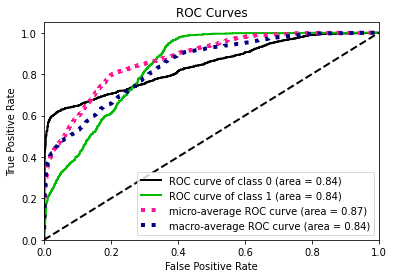

In [ ]:
skplt.metrics.plot_roc(test_label_svm.values, test_pred_proba_svm)

plt.show()

In [ ]:
models.append({
    'name': 'SVC', 
    'classifier': svm_classifier,
    'accuracy': accuracy_score(test_label_svm, test_pred_svm),
    'genuine_recall': recall_score(test_label_svm, test_pred_svm, pos_label = 0)
    })

## **Neural Network**

In [ ]:
users_nn_df = users_df.copy()

### **Preprocessing**

The 'lang' feature is converted as a one-hot numeric array in order to let the neural network to handle the indicator properly.

In [ ]:
users_nn_df = one_hot_encode(users_nn_df, ['lang'])

Before giving in input the data set to the neural network, the values are normalized to have mean 0 and variance 1.

In [ ]:
scaler = StandardScaler()

train_set_nn, test_set_nn, train_label_nn, test_label_nn = train_test_split(users_nn_df, label, stratify=label, test_size=0.30)

train_set_nn_norm = scaler.fit_transform(train_set_nn.values)
test_set_nn_norm = scaler.fit_transform(test_set_nn.values)


### **Feedforward neural network**

A feedforward neural network has connections only between nodes of level $L_i$ and the next one $L_{i+1}$.

The batch size is the number of training sample uses in each forward pass.

In [ ]:
BATCH_SIZE = 32

The neural network used for the classification is composed by three layers:
- the input layer is composed by as many neurons as the number of features of the data set. The layer is set as Flatten so as the output is flattened to a 1-D array, suitable for the next hidden layer
- the hidden layer is composed by a number of neurons equal to the square root of the number of features and is a Dense layer, then each node is connected to every node of the previous layer 
- the output layer has a single neuron, since the classification task is binary

In [ ]:
n_features = len(users_nn_df.iloc[0])

def get_basic_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(1, n_features)),
    tf.keras.layers.Dense(int(np.sqrt(n_features)), activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
  return model

The EarlyStopping callback is used to stop training when the validation loss metric has stopped improving.



In [ ]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

In [ ]:
y_train = np.asarray(train_label_nn).astype('float32').reshape((-1,1))
x_train = np.reshape(train_set_nn_norm, (train_set_nn_norm.shape[0], 1, train_set_nn_norm.shape[1]))

model = get_basic_model()

history = model.fit(x_train, y_train,
                    epochs=250,
                    batch_size=BATCH_SIZE,
                    validation_split=0.2,
                    callbacks=[earlystopping])

Epoch 1/250
202/202 [==============================] - 2s 3ms/step - loss: 0.7838 - accuracy: 0.4837 - val_loss: 0.6850 - val_accuracy: 0.6220
Epoch 2/250
202/202 [==============================] - 0s 2ms/step - loss: 0.6239 - accuracy: 0.7252 - val_loss: 0.5822 - val_accuracy: 0.7784
Epoch 3/250
202/202 [==============================] - 0s 2ms/step - loss: 0.5255 - accuracy: 0.7789 - val_loss: 0.5082 - val_accuracy: 0.7976
Epoch 4/250
202/202 [==============================] - 0s 2ms/step - loss: 0.4716 - accuracy: 0.7880 - val_loss: 0.4657 - val_accuracy: 0.8026
Epoch 5/250
202/202 [==============================] - 0s 2ms/step - loss: 0.4461 - accuracy: 0.7936 - val_loss: 0.4438 - val_accuracy: 0.8038
Epoch 6/250
202/202 [==============================] - 0s 2ms/step - loss: 0.4333 - accuracy: 0.7948 - val_loss: 0.4297 - val_accuracy: 0.8051
Epoch 7/250
202/202 [==============================] - 1s 3ms/step - loss: 0.4258 - accuracy: 0.7964 - val_loss: 0.4189 - val_accuracy: 0.8070

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 33)                0         
                                                                 
 dense (Dense)               (None, 5)                 170       
                                                                 
 dense_1 (Dense)             (None, 1)                 6         
                                                                 
Total params: 176
Trainable params: 176
Non-trainable params: 0
_________________________________________________________________


The following plots show the evolution of the loss and the accuracy through the epochs of the neural network.

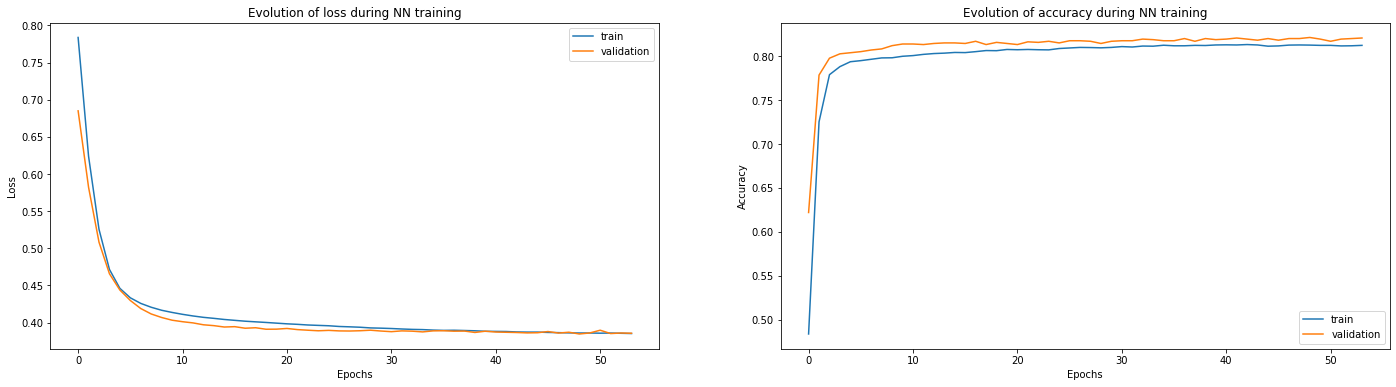

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(24,6))

ax[0].plot(history.history['loss'], label='train')
ax[0].plot(history.history['val_loss'], label='validation')
ax[0].set_title('Evolution of loss during NN training')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(history.history['accuracy'], label='train')
ax[1].plot(history.history['val_accuracy'], label='validation')
ax[1].set_title('Evolution of accuracy during NN training')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

#### **Evaluation**

After training the classifier, it is possible to make the predictions on the test set and compare the performances with respect to the training set.

In [ ]:
y_test = np.asarray(test_label_nn).astype('float32').reshape((-1,1))
x_test = np.reshape(test_set_nn_norm, (test_set_nn_norm.shape[0], 1, test_set_nn_norm.shape[1]))

In [ ]:
train_scores = model.evaluate(x_train, y_train, verbose=0)
test_scores = model.evaluate(x_test, y_test, verbose=0)

In [ ]:
print("Training loss: {loss}\nTraining accuracy: {accuracy}".format(loss = train_scores[0], accuracy = train_scores[1]))

Training loss: 0.38482218980789185
Training accuracy: 0.8139044046401978


In [ ]:
print("Test loss: {loss}\nTest accuracy: {accuracy}".format(loss = test_scores[0], accuracy = test_scores[1]))

Test loss: 0.4193343222141266
Test accuracy: 0.8149435520172119


The feedforward neural network has an accuracy of ~80% on the test set.

In [ ]:
train_pred_nn = model.predict(x_train, verbose=0) > 0.5
test_pred_nn = model.predict(x_test, verbose=0) > 0.5

In [ ]:
print ('Feedforward NN Classifier performance on training set: \n')
report_scores(train_label_nn, train_pred_nn)

Feedforward NN Classifier performance on training set: 

              precision    recall  f1-score   support

     Genuine       0.95      0.63      0.76      3774
         Bot       0.75      0.97      0.85      4281

    accuracy                           0.81      8055
   macro avg       0.85      0.80      0.80      8055
weighted avg       0.85      0.81      0.81      8055



In [ ]:
print ('Feedforward NN Classifier performance on test set: \n')
report_scores(test_label_nn, test_pred_nn)

Feedforward NN Classifier performance on test set: 

              precision    recall  f1-score   support

     Genuine       0.95      0.64      0.76      1618
         Bot       0.75      0.97      0.85      1835

    accuracy                           0.81      3453
   macro avg       0.85      0.80      0.81      3453
weighted avg       0.84      0.81      0.81      3453



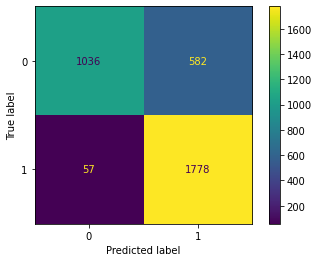

In [ ]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_label_nn, test_pred_nn)).plot()

plt.show() 

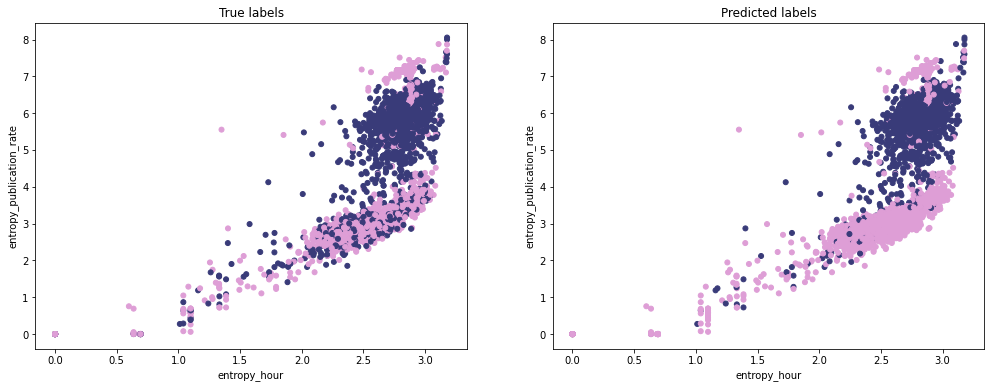

In [ ]:
compare_plots(test_set_nn, test_label_nn, test_pred_nn)

The feedforward neural network shows good results in the precision for the genuine users and the recall for bot users, but the number of false positive is fairly higher if compared to other models such as Random Forest.

Neural networks are not particularly suited for this kind of task, and the built feedforward model is maybe too simple to obtain better performances over the data set.

In [ ]:
models.append({
    'name': 'Feedforward NN', 
    'classifier': model,
   'accuracy': accuracy_score(test_label_nn, test_pred_nn),
    'genuine_recall': recall_score(test_label_nn, test_pred_nn, pos_label = 0)
    })

### **Multilayer perceptron**

The MLPClassifier is based on a multilayer perceptron neural network that trains using backpropagation.

#### **Finding the best parameters**

The following parameters are set up in advance to reduce the search space for the grid search, otherwise the time to find the best combination would have required too much time. The values are chosen after running experiments to find the most performing ones for this data set.
- 'activation': activaction function for the hidden layer(s)
- 'solver': solver for weight optimization
- 'learning_rate': controls how much to change the model in response to the estimated error each time the model weights are updated

In [ ]:
activation = 'relu'
solver = 'adam'
learning_rate = 'adaptive'

A grid search is performed to find the best values combination for the parameters:
- 'hidden_layer_sizes': the $i$-th element represents the number of neurons in the $i$-th hidden layer.
- 'alpha': strength of the L2 regularization term

In [ ]:
mlp_params_grid = {
    'hidden_layer_sizes': [100, 150, 15, 1, 30, 200, (15, 15), (200, 150), (30, 5)],
    'alpha': 10.0 ** -np.arange(1, 7)
}

grid_search_mlp = GridSearchCV(
    estimator=MLPClassifier(
        random_state=42, 
        max_iter=300,
        activation= activation,
        solver = solver,
        learning_rate = learning_rate), 
    param_grid=mlp_params_grid, 
    n_jobs=-1,
    scoring='accuracy')

grid_search_mlp.fit(train_set_nn_norm, train_label_nn)

grid_search_mlp.best_params_


{'alpha': 0.1, 'hidden_layer_sizes': (30, 5)}

The cv accuracy obtained by the Multilayer perceptron classifier for this data set is 80%.

In [ ]:
print('Accuracy score:', 
      grid_search_mlp.cv_results_['mean_test_score'][grid_search_mlp.best_index_], 
      '±',
      grid_search_mlp.cv_results_['std_test_score'][grid_search_mlp.best_index_])

Accuracy score: 0.810552451893234 ± 0.0045002033421208945


#### **Evaluation**

The classifier is built again with the best parameters obtained by the grid search.

In [ ]:
mlp_classifier = MLPClassifier(
    random_state=42, 
    max_iter=300,
    activation= activation,
    solver = solver,
    learning_rate = learning_rate,
    **grid_search_mlp.best_params_)

mlp_classifier.fit(train_set_nn_norm, train_label_nn)

MLPClassifier(alpha=0.1, hidden_layer_sizes=(30, 5), learning_rate='adaptive',
              max_iter=300, random_state=42)

In [ ]:
test_pred_proba_mlp = mlp_classifier.predict_proba(test_set_nn_norm)

test_pred_proba_mlp

array([[9.99903669e-01, 9.63314159e-05],
       [3.32409282e-01, 6.67590718e-01],
       [9.83999488e-01, 1.60005117e-02],
       ...,
       [9.99983749e-01, 1.62505079e-05],
       [9.99771047e-01, 2.28952887e-04],
       [3.90301547e-09, 9.99999996e-01]])

After training the classifier, it is possible to make the predictions on the test set and compare the performances with respect to the training set.

In [ ]:
train_pred_mlp = mlp_classifier.predict(train_set_nn_norm)
test_pred_mlp = mlp_classifier.predict(test_set_nn_norm)

In [ ]:
print('Accuracy train set ', accuracy_score(train_label_nn, train_pred_mlp))
print('Accuracy test set ', accuracy_score(test_label_nn, test_pred_mlp))

Accuracy train set  0.8336436995654872
Accuracy test set  0.808282652765711


In [ ]:
print ('Multilayer perceptron NN performance on training set: \n')
report_scores(train_label_nn, train_pred_mlp)

Multilayer perceptron NN performance on training set: 

              precision    recall  f1-score   support

     Genuine       0.98      0.66      0.79      3774
         Bot       0.77      0.99      0.86      4281

    accuracy                           0.83      8055
   macro avg       0.87      0.82      0.83      8055
weighted avg       0.87      0.83      0.83      8055



In [ ]:
print ('Multilayer perceptron NN performance on test set: \n')
report_scores(test_label_nn, test_pred_mlp)

Multilayer perceptron NN performance on test set: 

              precision    recall  f1-score   support

     Genuine       0.92      0.65      0.76      1618
         Bot       0.75      0.95      0.84      1835

    accuracy                           0.81      3453
   macro avg       0.84      0.80      0.80      3453
weighted avg       0.83      0.81      0.80      3453



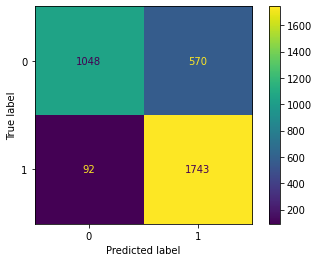

In [ ]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_label_nn, test_pred_mlp)).plot()

plt.show() 

The MLPClassifier shows better performance with respect to the classifier based on the previous feedforward network, but still it can't reach a recall for the genuine users comparable to the one obtained by the Random forest classifier.

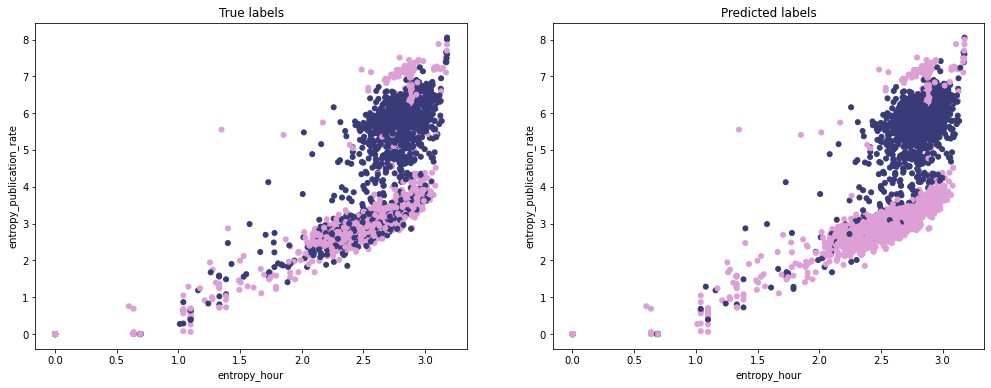

In [ ]:
compare_plots(test_set_nn, test_label_nn, test_pred_mlp)

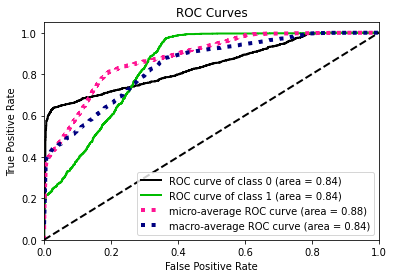

In [ ]:
skplt.metrics.plot_roc(test_label_nn.values, test_pred_proba_mlp)

plt.show()

From the ROC curves plotted above it is possible to see that the behavior of the MLPClassifier is very similar to the one of the SVC. Also in this case, for the class 0 (genuine users), the classifier need to significantly increate the FP rate to obtain good values for the TP rate.

In [ ]:
models.append({
    'name': 'Multilayer perceptron NN', 
    'classifier': mlp_classifier,
    'accuracy': accuracy_score(test_label_nn, test_pred_mlp),
    'genuine_recall': recall_score(test_label_nn, test_pred_mlp, pos_label = 0)
    })

## **Comparison of the classifiers**


Comparing the accuracy obtained by each model built during this classification task it is possible to observe that:
- All the models outperform the baseline performance by a 25/30% factor
- The naive bayes classifiers are the worst performing, due to the general high skewness of the features included in the data set
- The classifiers based on neural networks are not the best models for this classification task, probably due to the unclear separation between bots and genuine users for many attributes' values
- Decision tree classifier shows good performance, being able to produce a remarkable accuracy
- Enseble methods based on decision trees are the best performing ones, reaching an accuracy of 84%, thanks to their ability to exploit the conjunction of simple classifiers to better fit the data

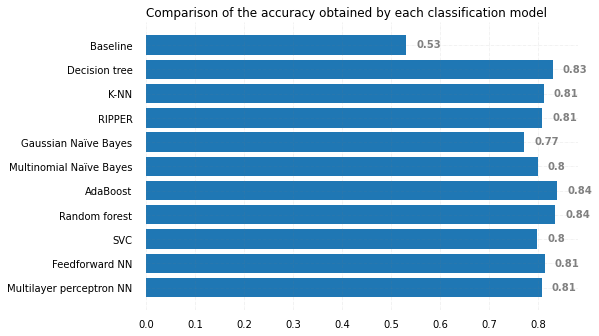

In [ ]:
accs = []
names = []

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

for model in models:
  name = model.get('name')
  accuracy = model.get('accuracy')
  names.append(name)
  accs.append(accuracy)

# Horizontal Bar Plot
ax.barh(names, accs)
 
# Remove axes spines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad=5)
ax.yaxis.set_tick_params(pad=10)
 
# Add x, y gridlines
ax.grid(b=True, color='grey',
        linestyle='-.', linewidth=0.5,
        alpha=0.2)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.02, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize=10, fontweight='bold',
             color='grey')
 
# Add Plot Title
ax.set_title('Comparison of the accuracy obtained by each classification model',
             loc='left', )
 
# Show Plot
plt.show()

For what concerns the recall over genuine users obtained by each classification model the results are quite analogous; the models with the best recall score for genuine users are the ensemble methods Random forest and AdaBoost, in addition to the Decision tree classifier, whereas the worst performing ones are the Naive Bayes classifiers and SVC. 

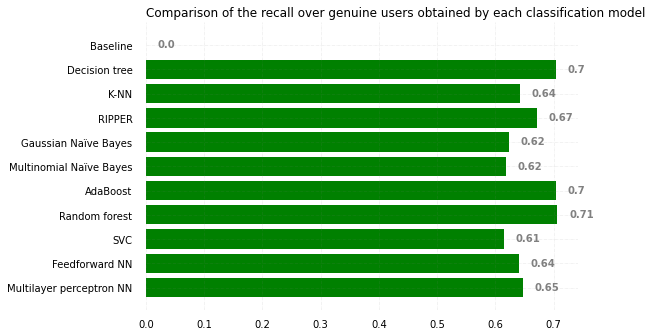

In [ ]:
recalls = []
names = []

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

for model in models:
  name = model.get('name')
  recall = model.get('genuine_recall')
  names.append(name)
  recalls.append(recall)

# Horizontal Bar Plot
ax.barh(names, recalls, color='green')
 
# Remove axes spines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad=5)
ax.yaxis.set_tick_params(pad=10)
 
# Add x, y gridlines
ax.grid(b=True, color='grey',
        linestyle='-.', linewidth=0.5,
        alpha=0.2)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.02, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize=10, fontweight='bold',
             color='grey')
 
# Add Plot Title
ax.set_title('Comparison of the recall over genuine users obtained by each classification model',
             loc='left', )
 
# Show Plot
plt.show()